In [1]:
import wandb
import torch
import numpy as np
import math
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import torch.nn as nn

from models.resnet.resnet18 import ResNet18
from datasets.cifar100_dataset import CIFAR100Dataset
from utils.dataset_utils import train_test_split, get_transformation
from utils.cifar100_utils import CIFAR100_LABELS, get_superclass, CIFAR100_DECODING

from models.moe_layer.resnet18.resnet18_moe import ResNet18MoE
from models.moe_layer.soft_gating_networks import SimpleGate
from models.moe_layer.resnet.moe_block_layer import ResidualMoeBlockLayer, MoeBlockLayer
from models.moe_layer.resnet18.resnet18_experts import NarrowResNet18Expert

In [2]:
gate = SimpleGate(
    in_channels=256, 
    num_experts=10,
    top_k=2,
    use_noise=True,
    name='SimpleGate',
    loss_fkt='importance',
    w_aux_loss=0.5
    )
        
moe_layer = MoeBlockLayer(
    num_experts=10, 
    layer_position=4, 
    top_k=2,
    gating_network=gate,
    resnet_expert=NarrowResNet18Expert)

model = ResNet18MoE(
    moe_layers=[moe_layer],
)

file_model = wandb.restore('Default_10_topK=2_loss=kl_divergence_w_aux=0.5_moePosition=4_2_final.tar', run_path='lukas-struppek/final_resnet_18/3mve6uzu')
model.load_state_dict(torch.load(file_model.name)['model_state_dict'])
model = model.to(model.device)

In [3]:
transformations_test = get_transformation('cifar100', phase='test')
no_transform = get_transformation('no_transform')
cifar_test = CIFAR100Dataset(root_dir='/home/lb4653/mixture-of-experts-thesis/data/cifar100/testing', transform=transformations_test)
cifar_test_no_transform = CIFAR100Dataset(root_dir='/home/lb4653/mixture-of-experts-thesis/data/cifar100/testing', transform=no_transform)
dataloader = torch.utils.data.DataLoader(cifar_test, batch_size=256)

In [4]:
class Hook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.inputs = []
        self.outputs = []
        self.weights = []
        self.selected_experts = []
        
    def hook_fn(self, module, input, output):
        for pred in output:
            self.outputs.append(pred.detach().cpu().numpy())
            top_k_logits, top_k_indices = pred.topk(2)
            top_k_weights = nn.functional.softmax(top_k_logits)
            weights = torch.zeros(10, requires_grad=False)
            weights[top_k_indices[0]] = top_k_weights[0]
            weights[top_k_indices[1]] = top_k_weights[1]
            self.weights.append(weights.detach().cpu().numpy())
            experts = [top_k_indices[0].cpu().item(), top_k_indices[1].cpu().item()]
            self.selected_experts.append(experts)
        
    def close(self):
        self.hook.remove()


In [5]:
hook = Hook(model.layers[-1].gate.fc)

In [6]:
labels = []
superclass_labels = []
for image, label in dataloader:
    for l in label:
        labels.append(CIFAR100_DECODING[l.cpu().item()])
        superclass_labels.append(get_superclass(CIFAR100_DECODING[l.cpu().item()]))
    model(image.to('cuda:0'))

In [11]:
tsne = TSNE(n_components=2, perplexity=5, learning_rate=10, verbose=1, n_iter=1000).fit_transform(hook.outputs)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 0.506s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.536615
[t-SNE] KL divergence after 250 iterations with early exaggeration: 104.537476
[t-SNE] KL divergence after 1000 iterations: 3.146189


In [12]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

df_subset = dict()
df_subset['tsne-2d-one'] = tx
df_subset['tsne-2d-two'] = ty

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

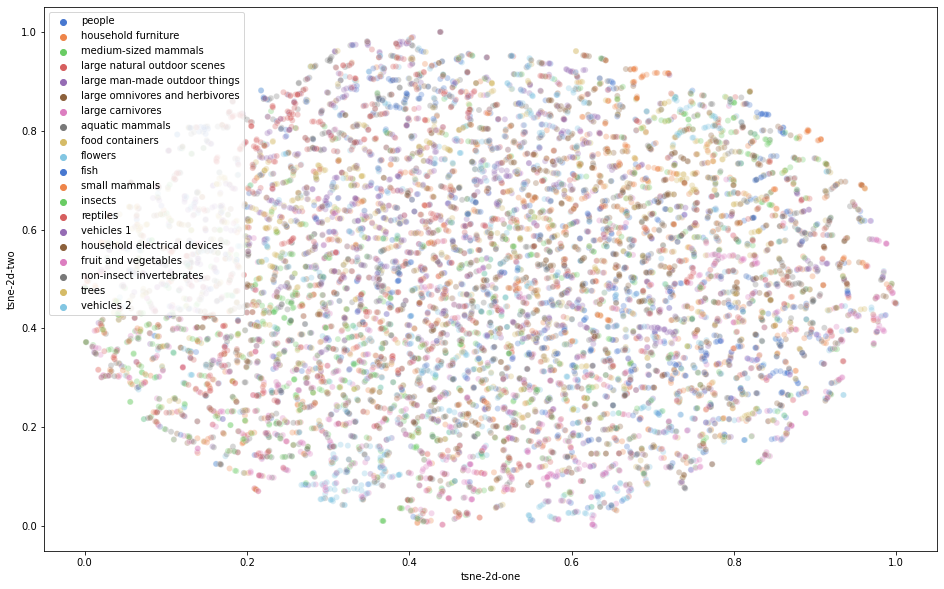

In [17]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=superclass_labels,
    palette=sns.color_palette("muted", 20),
    data=df_subset,
    legend="full",
    alpha=0.3
)


In [14]:
from torchvision import transforms

width = 4000
height = 3000
max_dim = 100
full_image = Image.new('RGB', (width, height))
for idx, x in enumerate(cifar_test_no_transform):
    tile = transforms.ToPILImage()(x[0].squeeze_(0))

    rs = max(1, tile.width / max_dim, tile.height / max_dim)
    tile = tile.resize((int(tile.width / rs),
                        int(tile.height / rs)),
                       Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim) * tx[idx]),
                            int((height-max_dim) * ty[idx])))
full_image.save('test2.jpg')